# Speech Commands to Spectrograms and Model Training

This document provides a complete guide to generate spectrogram images from the Speech Commands dataset and train a Convolutional Neural Network (CNN) model on these images.

## Prerequisites

Before you begin, ensure you have the following installed:
- Python 3.6 or later
- pip

## Required Libraries

Install the required libraries using pip:

```bash
pip install torch torchvision matplotlib librosa numpy


## Instructions to Download Dataset and Convert to Spectrogram Images

### Download the Dataset

1. Go to the [Speech Commands Dataset](https://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz) page.
2. Download the dataset by clicking on the link or using the following command in your terminal:
    ```bash
    wget https://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz
    ```
3. Extract the downloaded tar.gz file:
    ```bash
    tar -xvf speech_commands_v0.02.tar.gz
    ```



In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import IPython.display as ipd

### Load the Audio File
The `load_audio` function loads an audio file and returns the waveform and sample rate.

In [2]:
def load_audio(filename):
    waveform, sample_rate = librosa.load(filename, sr=None)
    print(f'Waveform shape: {waveform.shape}')
    print(f'Sample rate: {sample_rate}')
    return waveform, sample_rate

- `filename`: Path to the audio file.
- `waveform`: The audio signal.
- `sample_rate`: The sampling rate of the audio file.

### Extract Frames
Extract the first 3 frames:

In [3]:
def extract_frames(waveform, num_frames=3, frame_offset=0):
    extracted_frames = waveform[frame_offset:frame_offset + num_frames]
    return extracted_frames

- `num_frames`: Number of frames to extract.
- `frame_offset`: Starting position for frame extraction.

### Visualize the Waveform, Spectrogram, and Mel Spectrogram
Plot the waveform:

In [4]:
def plot_waveform(waveform, sample_rate, title="Waveform"):
    plt.figure(figsize=(10, 4))
    plt.plot(waveform)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.show()

Show the spectrogram:

In [5]:
def show_spectrogram(waveform, sample_rate, title="Spectrogram"):
    D = librosa.amplitude_to_db(np.abs(librosa.stft(waveform)), ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(D, sr=sample_rate, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()

Show the mel spectrogram:

In [6]:
def show_melspectrogram(waveform, sample_rate, title="Mel Spectrogram"):
    S = librosa.feature.melspectrogram(y=waveform, sr=sample_rate, n_mels=128)
    S_DB = librosa.amplitude_to_db(S, ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_DB, sr=sample_rate, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()

In [7]:
# File path
filename = "/Users/tayalarajan.tr/Documents/Online Courses/PyTorch/Untitled Folder/data/SpeechCommands/speech_commands_v0.02/yes/00f0204f_nohash_0.wav"

# Load the audio file
waveform, sample_rate = load_audio(filename)

# Extract the first 3 frames
waveform_first_3_frames = extract_frames(waveform, num_frames=3)
print(f'Waveform tensor with 3 frames: {waveform_first_3_frames}')

# Extract 3 frames starting from frame offset 2
waveform_with_offset = extract_frames(waveform, num_frames=3, frame_offset=2)
print(f'Waveform tensor with 2 frame_offsets: {waveform_with_offset}')

Waveform shape: (16000,)
Sample rate: 16000
Waveform tensor with 3 frames: [0.00048828 0.00067139 0.00054932]
Waveform tensor with 2 frame_offsets: [0.00054932 0.00036621 0.0007019 ]


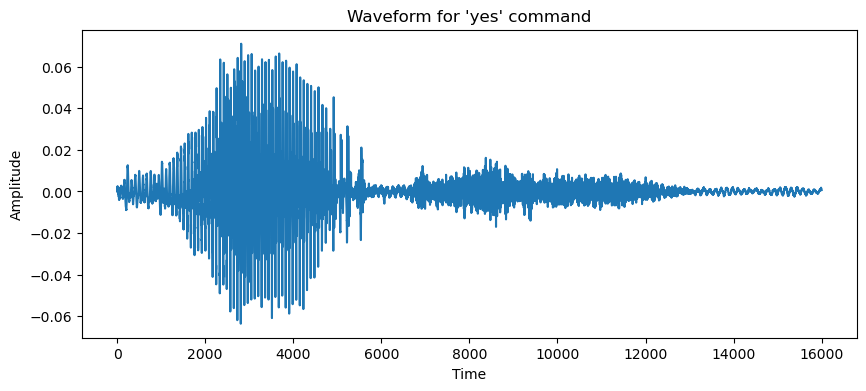

In [8]:
# Plot the waveform
plot_waveform(waveform, sample_rate, title="Waveform for 'yes' command")

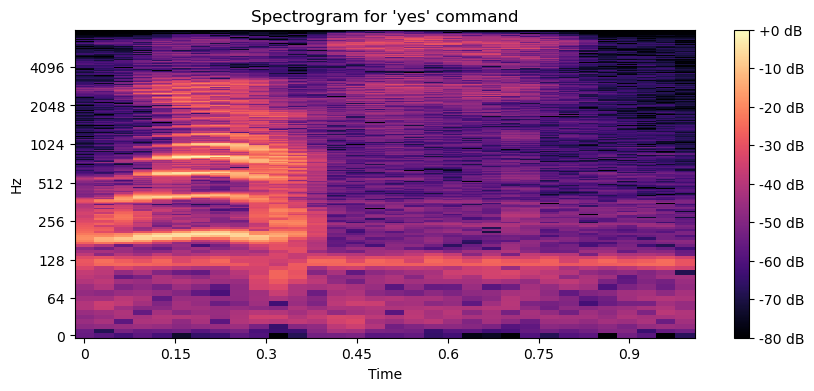

In [9]:
# Show the spectrogram
show_spectrogram(waveform, sample_rate, title="Spectrogram for 'yes' command")

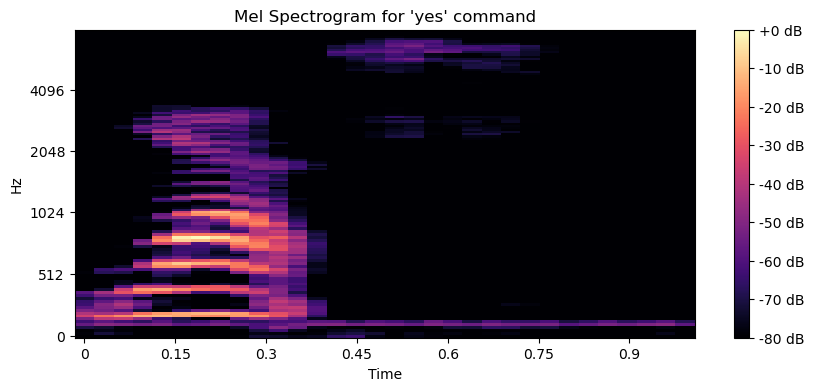

In [10]:
# Show the Mel spectrogram
show_melspectrogram(waveform, sample_rate, title="Mel Spectrogram for 'yes' command")

# Play the audio
ipd.display(ipd.Audio(waveform, rate=sample_rate))

### Save Spectrogram Image

In [11]:
def save_spectrogram_image(y, sr, out_path):
    plt.figure(figsize=(2, 1))  # Resize the figure
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.axis('off')
    plt.savefig(out_path, bbox_inches='tight', pad_inches=0)
    plt.close()

### Generate Spectrograms for Dataset
The generate_spectrograms function creates spectrogram images for all audio files in specified directories.

In [12]:
def generate_spectrograms(data_dir, out_dir, labels=('yes', 'no')):
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    for label in labels:
        input_dir = os.path.join(data_dir, label)
        output_dir = os.path.join(out_dir, label)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        for filename in os.listdir(input_dir):
            if filename.endswith('.wav'):
                filepath = os.path.join(input_dir, filename)
                y, sr = librosa.load(filepath, sr=None)
                out_path = os.path.join(output_dir, filename.replace('.wav', '.png'))
                save_spectrogram_image(y, sr, out_path)

### Generate Spectrograms for 'yes' and 'no' Labels

In [13]:
data_path = "/Users/tayalarajan.tr/Documents/Online Courses/PyTorch/Untitled Folder/data/SpeechCommands/speech_commands_v0.02"
spectrogram_data_path = "./data/spectrograms/train"
generate_spectrograms(data_path, spectrogram_data_path, labels=('yes', 'no'))

### Define Data Transformations

In [14]:
transform = transforms.Compose([
    transforms.Resize((201, 81)),
    transforms.ToTensor()
])

### Load Dataset

In [15]:
yes_no_dataset = datasets.ImageFolder(root=spectrogram_data_path, transform=transform)
print(yes_no_dataset)

Dataset ImageFolder
    Number of datapoints: 7985
    Root location: ./data/spectrograms/train
    StandardTransform
Transform: Compose(
               Resize(size=(201, 81), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


### Split Dataset into Training and Validation Sets

In [16]:
train_size = int(0.8 * len(yes_no_dataset))
val_size = len(yes_no_dataset) - train_size
train_dataset, val_dataset = random_split(yes_no_dataset, [train_size, val_size])

### Create DataLoaders

In [17]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

### Define the CNN Model

In [18]:
class CNNet(nn.Module):
    def __init__(self):
        super(CNNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.dropout = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(64 * 50 * 20, 50)
        self.fc2 = nn.Linear(50, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(-1, 64 * 50 * 20)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Initialize Model, Loss Function, and Optimizer

In [19]:
model = CNNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Training Loop

In [20]:
# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Validation Accuracy: {100 * correct / total}%")

# Save the model
torch.save(model.state_dict(), "speech_model.pth")

Epoch 1, Loss: 0.2935836632922292
Validation Accuracy: 93.17470256731372%
Epoch 2, Loss: 0.15240756766870617
Validation Accuracy: 94.61490294301817%
Epoch 3, Loss: 0.09893737429752945
Validation Accuracy: 95.17845961177207%
Epoch 4, Loss: 0.08038308445131406
Validation Accuracy: 95.80463368816531%
Epoch 5, Loss: 0.06050811661873013
Validation Accuracy: 96.36819035691923%
Epoch 6, Loss: 0.04847513405402424
Validation Accuracy: 96.74389480275516%
Epoch 7, Loss: 0.042821870634215886
Validation Accuracy: 95.92986850344396%
Epoch 8, Loss: 0.041933022094381156
Validation Accuracy: 97.11959924859111%
Epoch 9, Loss: 0.029530945181832066
Validation Accuracy: 97.05698184095178%
Epoch 10, Loss: 0.027545513038708124
Validation Accuracy: 96.86912961803381%
Epoch 11, Loss: 0.029646844712585788
Validation Accuracy: 97.18221665623044%
Epoch 12, Loss: 0.021442655650248527
Validation Accuracy: 97.6205385097057%
Epoch 13, Loss: 0.017635568676812454
Validation Accuracy: 97.43268628678773%
Epoch 14, Loss: 